In [11]:
import osmnx as ox
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import pickle
import time
import seaborn as sns
from shapely.geometry import LineString, Point

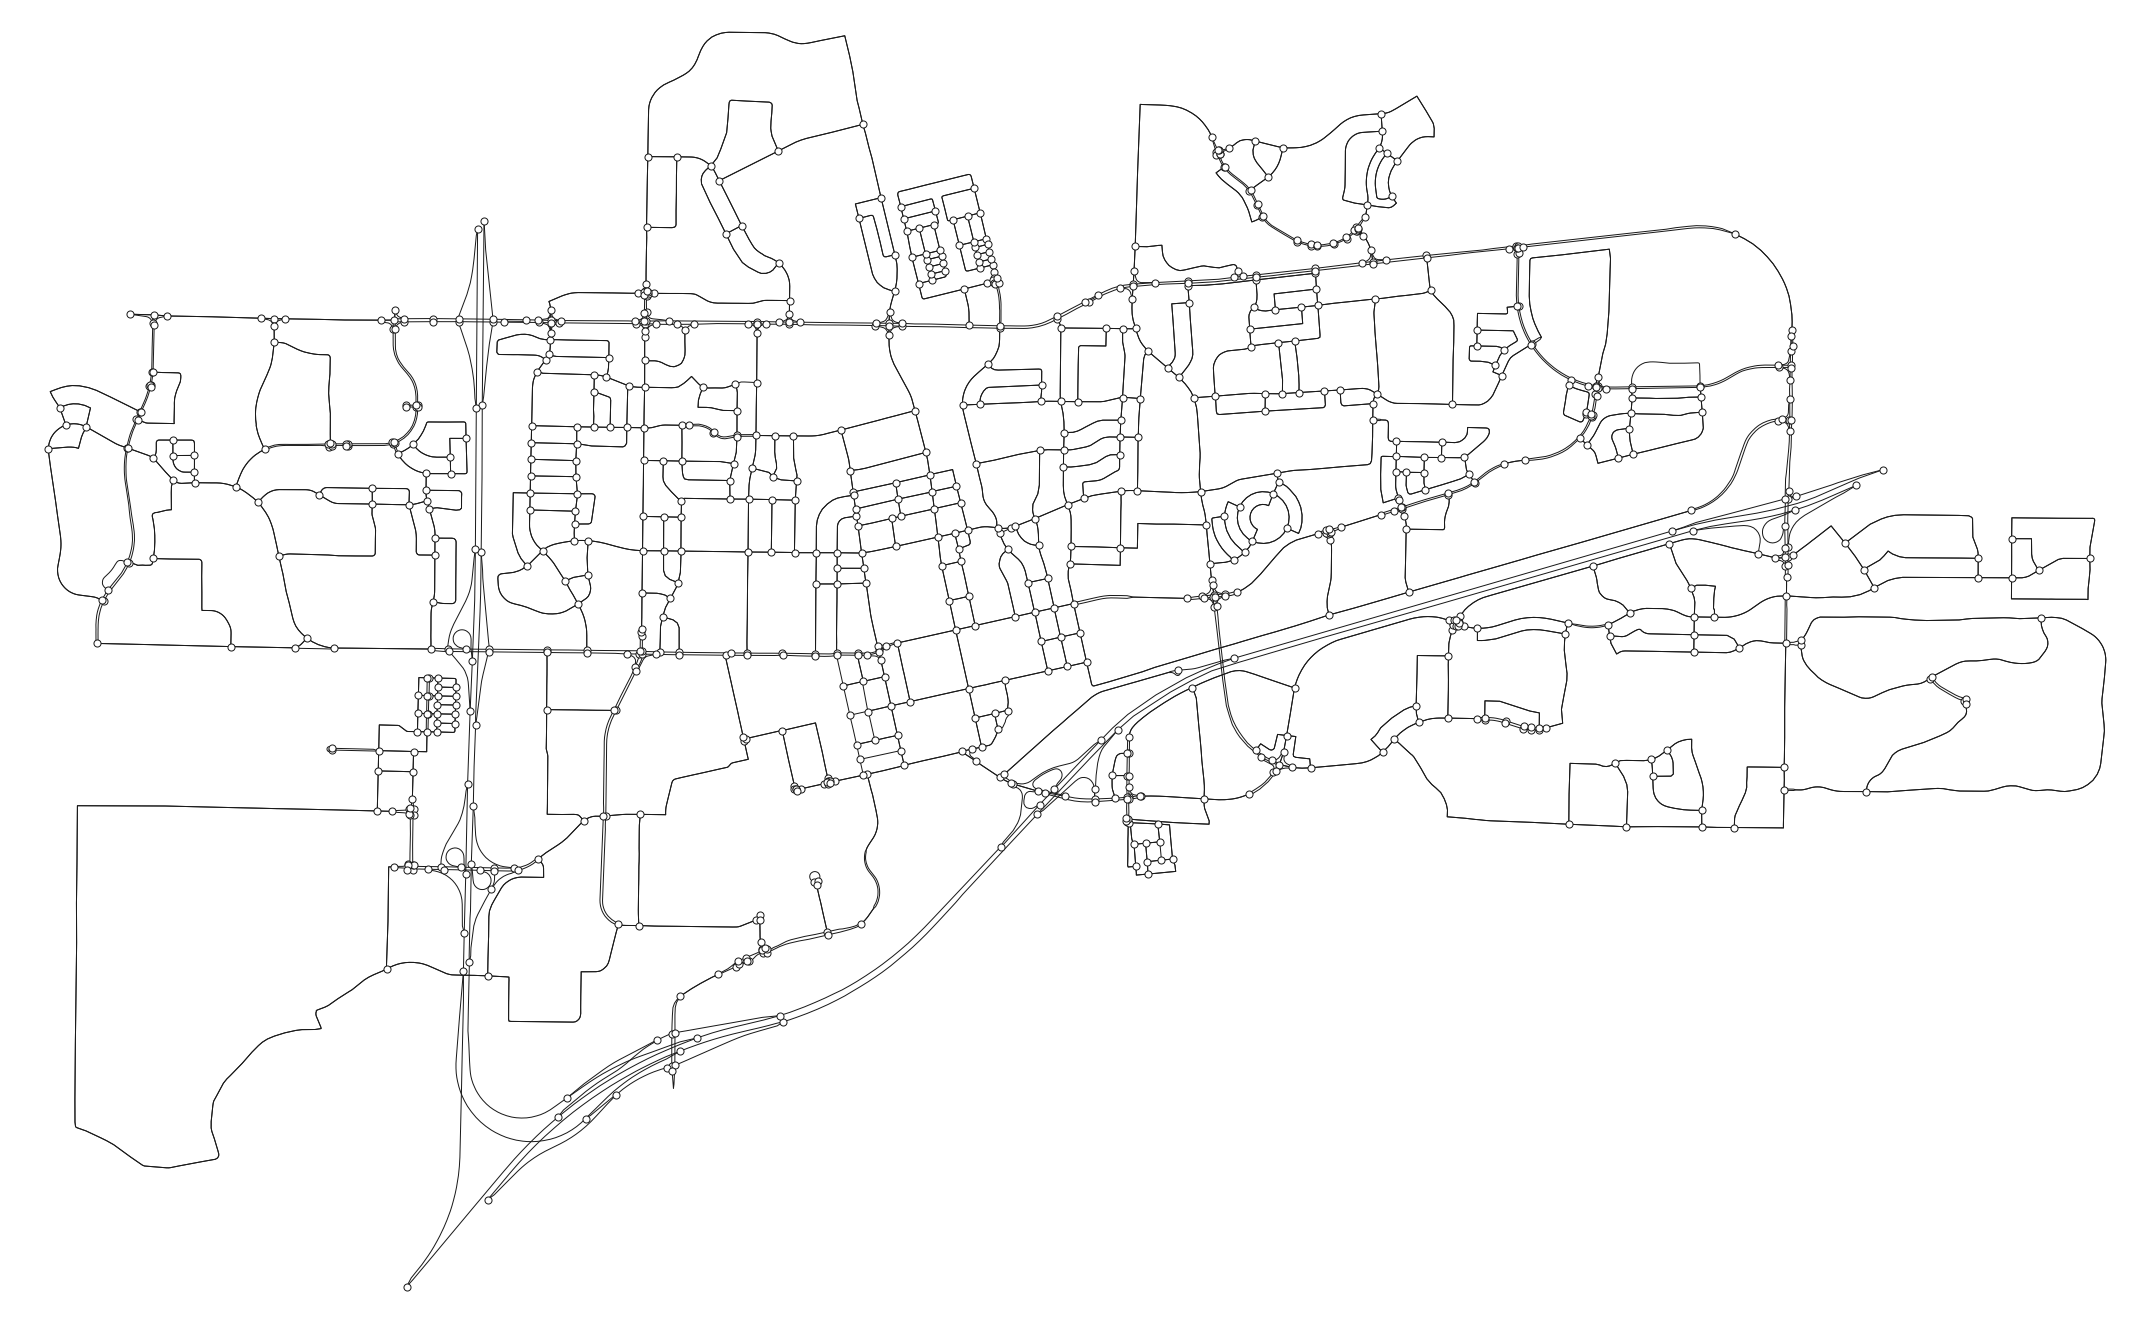

In [13]:
# load road network from a binary pickle file 
fname = 'Davis_simplified_graph.pkl'
rf = open(fname,"rb")
G = pickle.load(rf)
rf.close()


# Change edge key to 1 (This simplified graph does not have multiple edges)
nonZero_keys = []
for edge in G.edges(keys=True, data=True):
    u,v,k,d = edge
    if k != 0:
        nonZero_keys.append(edge)
for u,v,k,d in nonZero_keys:
    G.add_edge(u, v, key=0, **d)
    G.remove_edge(u, v, key=k)

# Refine edge type
etype_val = {'motorway':0, 'motorway_link':1, 'primary':2, 'primary_link':3,
               'secondary':4, 'secondary_link':5, 'tertiary':6, 'tertiary_link':7,
               'residential':8, 'unclassified':9}

for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    
    # Set the most slow edge type for consolidated edges
    if type(edge_type) == list:
        edge_type = sorted(edge_type, reverse=True, key = lambda d: etype_val[d])
        edge_type = edge_type[0]
        G.edges[edge]['highway'] = edge_type

# Set default speed of vehicles on each type of road
hwy_speeds = {'motorway': 110,
            'motorway_link': 60,
            'primary': 60,
            'primary_link': 60,
            'secondary': 50,
            'secondary_link': 50,
            'tertiary': 40,
            'tertiary_link': 40,
            'residential': 40,
            'unclassified': 40}

# Plug in to the graph. 'speed_kph' attribute is added to each edge and set to the default speed.
G = ox.add_edge_speeds(G, hwy_speeds)

# Add 'travel_time' property to each node, which is 'length' divided by 'speed_kph'
G = ox.add_edge_travel_times(G)

# Add signal light delay on the travel_time attributes
for edge in G.edges:
    edge_type = G.edges[edge]['highway']
    edge_len = G.edges[edge]['length']
    signal_delay = 0

    if edge_type == 'primary':
        signal_delay = 10

    elif edge_type == 'secondary':
        signal_delay = 10

    elif edge_type == 'tertiary':
        signal_delay = 6

    elif edge_type == 'residential':
        signal_delay = 4
            
    G.edges[edge]['travel_time'] += signal_delay

travel_time = nx.get_edge_attributes(G, 'travel_time')
nx.set_edge_attributes(G, travel_time,'total_delay') # initialize 'total_delay' attributes
nx.set_edge_attributes(G, travel_time,'expected_delay') # initialize 'expected_delay' attributes

# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='w', node_size=50, node_edgecolor='k',
                        edge_linewidth=1,edge_color='k', show=False, close=False, bgcolor='w')

plt.show()
plt.close('all')

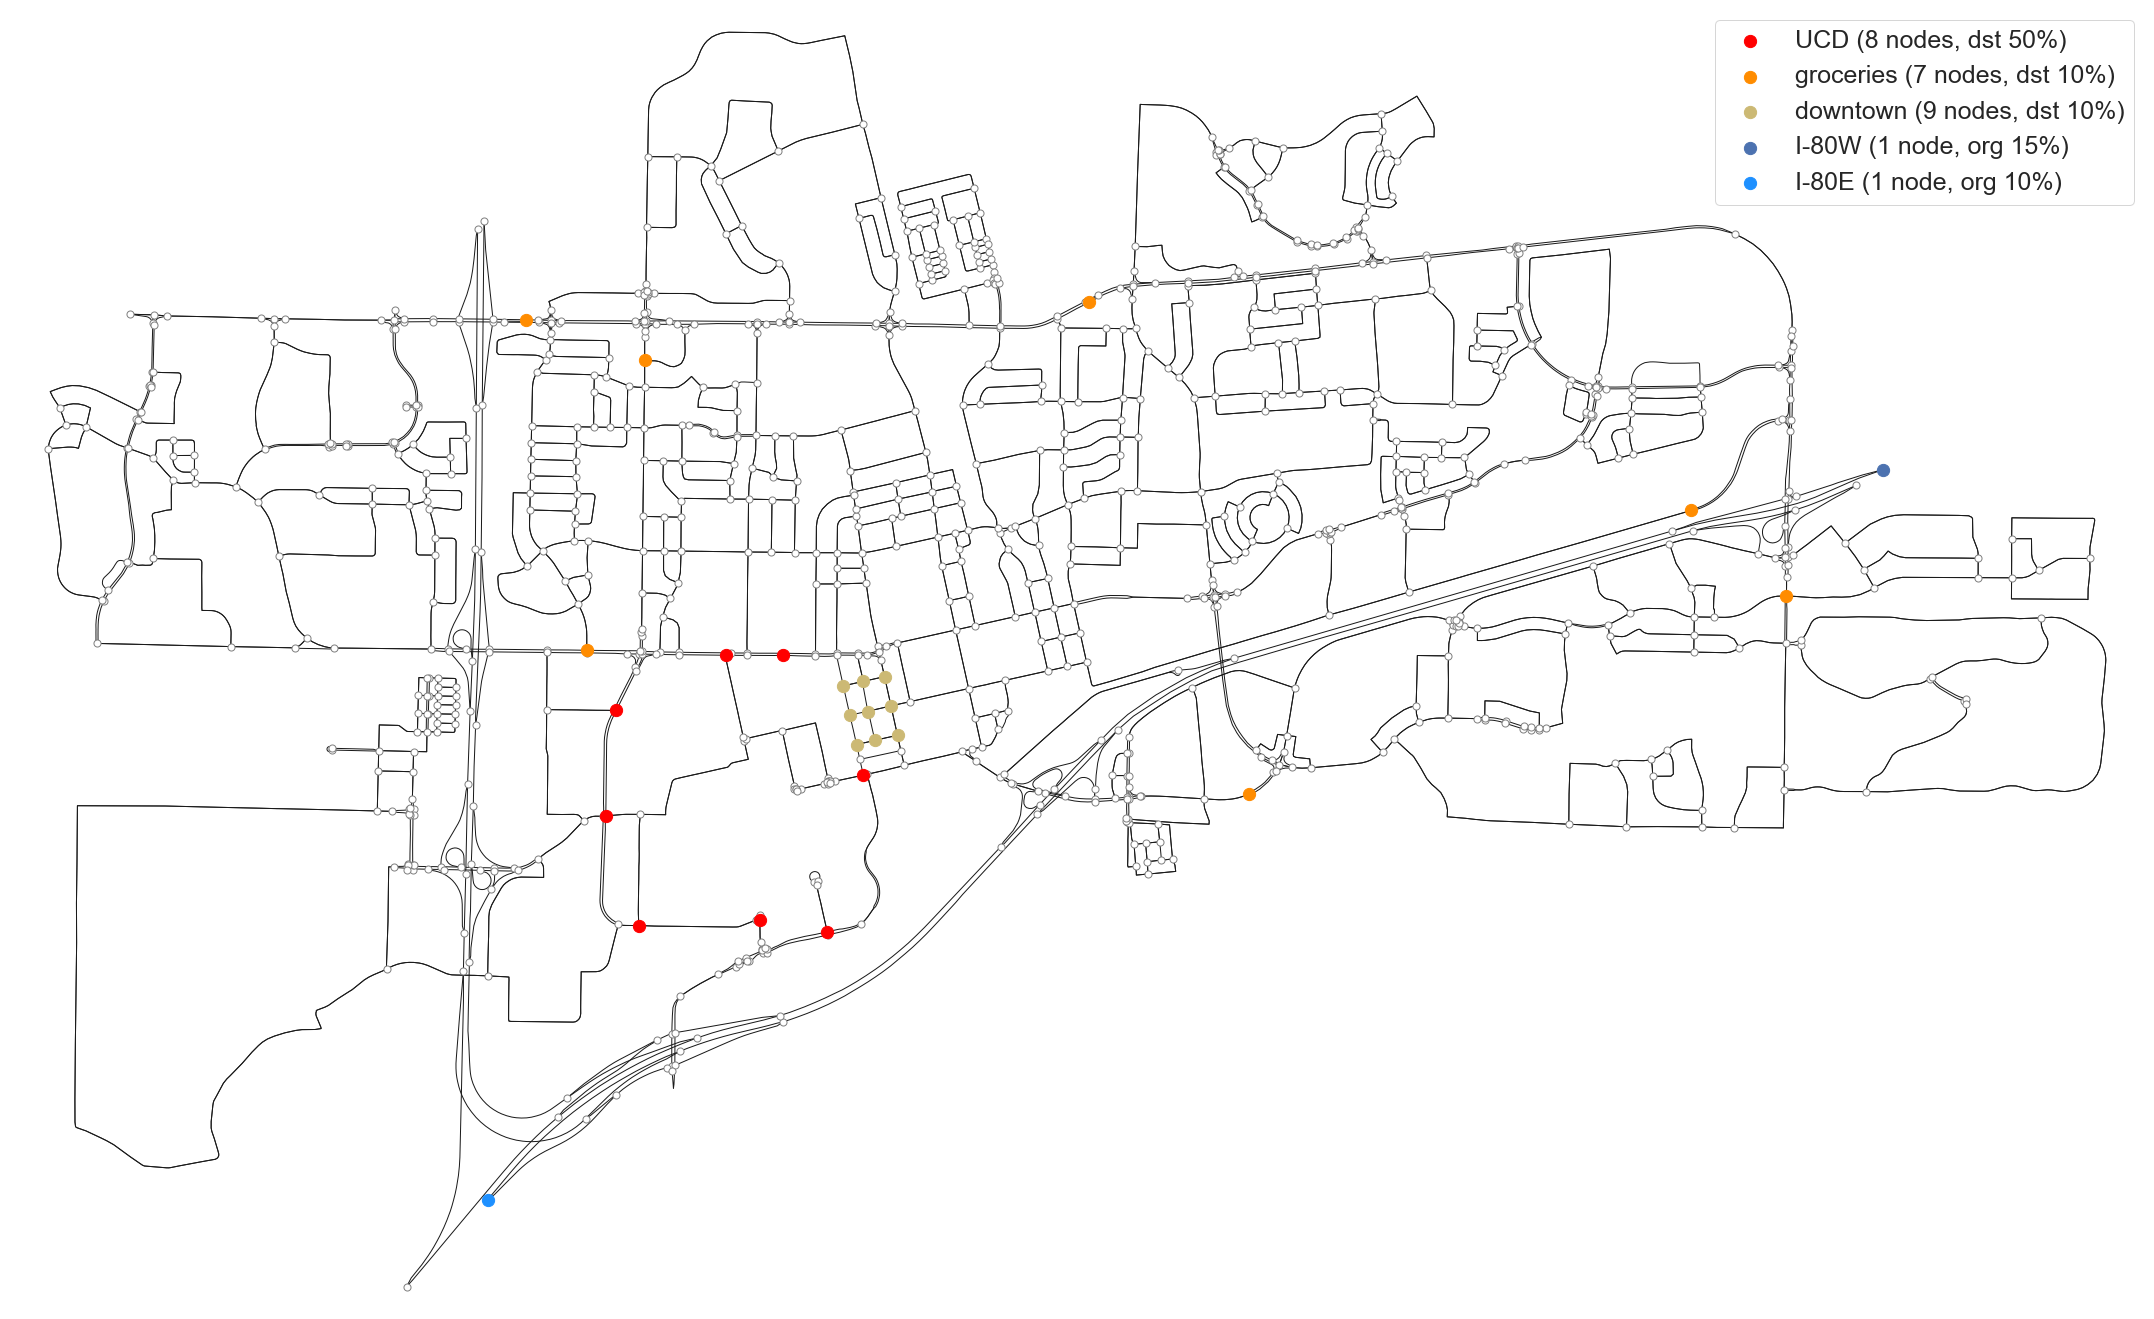

In [14]:
ucd = [
    2607436610, # ARC
    271792330, # Welcome Center
    2599137941, # North
    9138286032, # South
    2599137945, # MJ
    95709746, # Southwest
    95713435, # East
    2607436619 # West
]

groceries = [
    599394518, #Safeway (N) 
    95710949, #Safeway (S)
    95719103, #Savemart
    95714491, #TJ
    2580278625, #Nugget (N)
    95715589, #Nugget (S)
    95714168, #Target
]

downtown = [
    95713439,
    95719939,
    95713485,
    9146890354,
    9322338568,
    95711354,
    95713437,
    95714187,
    95713484
]

i80w = [
    267383938
]

i80e = [
    62224641
]

# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='w', node_size=50, node_edgecolor='grey',
                        edge_linewidth=1,edge_color='k', show=False, close=False, bgcolor='w')

mark_size = 150
ucd_x = []
ucd_y = []
for node in ucd:
    x_coord = G.nodes[node]['x']
    y_coord = G.nodes[node]['y']
    ucd_x.append(x_coord)
    ucd_y.append(y_coord)
ax.scatter(ucd_x, ucd_y, s=mark_size, c='red', label='UCD (8 nodes, dst 50%)')
    
groceries_x = []
groceries_y = []
for node in groceries:
    x_coord = G.nodes[node]['x']
    y_coord = G.nodes[node]['y']
    groceries_x.append(x_coord)
    groceries_y.append(y_coord)
ax.scatter(groceries_x, groceries_y, s=mark_size, c='darkorange', label='groceries (7 nodes, dst 10%)')
    
downtown_x = []
downtown_y = []
for node in downtown:
    x_coord = G.nodes[node]['x']
    y_coord = G.nodes[node]['y']
    downtown_x.append(x_coord)
    downtown_y.append(y_coord)
ax.scatter(downtown_x, downtown_y, s=mark_size, c='y', label='downtown (9 nodes, dst 10%)')
    
for node in i80w:
    x_coord = G.nodes[node]['x']
    y_coord = G.nodes[node]['y']
    ax.scatter(x_coord, y_coord, s=mark_size, c='b', label='I-80W (1 node, org 15%)')
    
for node in i80e:
    x_coord = G.nodes[node]['x']
    y_coord = G.nodes[node]['y']
    ax.scatter(x_coord, y_coord, s=mark_size, c='dodgerblue', label='I-80E (1 node, org 10%)')

plt.legend(prop={'size': 25})
plt.show()
plt.close('all')

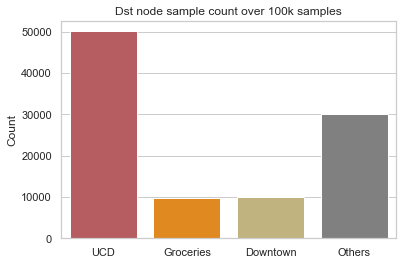

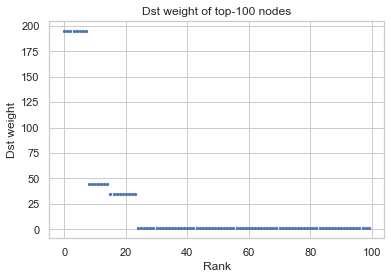

In [19]:
sns.set()

nx.set_node_attributes(G, 1, 'dst_w')

node_num = G.number_of_nodes()

# general nodes are sampled at 30% of probability
general_dst_num = node_num - len(ucd) - len(groceries) - len(downtown)

ucd_prob = general_dst_num * 5 / 3
downtown_prob = general_dst_num / 3
groceries_prob = general_dst_num / 3

for node in G.nodes():
    if node in ucd:
        G.nodes[node]['dst_w'] = ucd_prob / len(ucd)
    elif node in downtown:
        G.nodes[node]['dst_w'] = downtown_prob / len(downtown)
    elif node in groceries:
        G.nodes[node]['dst_w'] = groceries_prob / len(groceries)
        
nodes = list(G.nodes())
dst_weights = [G.nodes[node]['dst_w'] for node in nodes]

dst_cnt = {'UCD':0, 'Groceries':0, 'Downtown':0, 'Others':0}

sample_num = 100000
for _ in range(0, sample_num):
    dst_sample = random.choices(nodes, weights=dst_weights, k=1)[0]
    if dst_sample in ucd:
        dst_cnt['UCD'] += 1
    elif dst_sample in groceries:
        dst_cnt['Groceries'] += 1
    elif dst_sample in downtown:
        dst_cnt['Downtown'] += 1
    else:
        dst_cnt['Others'] += 1 
        
sns.set_theme(style="whitegrid")
sns.barplot(x=list(dst_cnt.keys()), y=list(dst_cnt.values()), palette=['r','darkorange', 'y', 'grey'])
plt.title('Dst node sample count over 100k samples')
plt.ylabel('Count')
plt.show()
plt.close('all')

plt.scatter(list(range(0,100)), sorted(dst_weights, reverse=True)[:100], s=5)
plt.title('Dst weight of top-100 nodes')
plt.ylabel('Dst weight')
plt.xlabel('Rank')
plt.show()
plt.close('all')

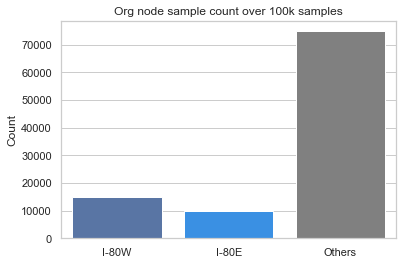

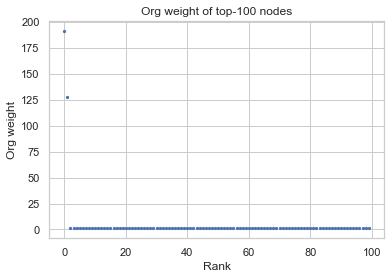

In [20]:
sns.set()

nx.set_node_attributes(G, 1, 'org_w')

node_num = G.number_of_nodes()

# general nodes are sampled at 30% of probability
general_org_num = node_num - len(i80w) - len(i80e)

i80w_prob = general_org_num * 15 / 75
i80e_prob = general_org_num * 10 / 75

for node in G.nodes():
    if node in i80w:
        G.nodes[node]['org_w'] = i80w_prob / len(i80w)
    elif node in i80e:
        G.nodes[node]['org_w'] = i80e_prob / len(i80e)
        
nodes = list(G.nodes())
org_weights = [G.nodes[node]['org_w'] for node in nodes]

org_cnt = {'I-80W':0, 'I-80E':0, 'Others':0}

sample_num = 100000
for _ in range(0, sample_num):
    org_sample = random.choices(nodes, weights=org_weights, k=1)[0]
    if org_sample in i80w:
        org_cnt['I-80W'] += 1
    elif org_sample in i80e:
        org_cnt['I-80E'] += 1
    else:
        org_cnt['Others'] += 1 
        
sns.set_theme(style="whitegrid")
sns.barplot(x=list(org_cnt.keys()), y=list(org_cnt.values()), palette=['b','dodgerblue', 'grey'])
plt.title('Org node sample count over 100k samples')
plt.ylabel('Count')
plt.show()
plt.close('all')

plt.scatter(list(range(0,100)), sorted(org_weights, reverse=True)[:100], s=5)
plt.title('Org weight of top-100 nodes')
plt.ylabel('Org weight')
plt.xlabel('Rank')
plt.show()
plt.close('all')

In [21]:
## Compute betweenness centrality weighted by 'length' and 'aggr_node_num'              
def accumulate_sigma(G, path, bc_dic, multiple, weight='travel_time'):    
    for u, v in zip(path[:-1], path[1:]):
        all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
        edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1][weight])
        shortest_edge_key = edge_dat_sorted_by_length[0][0]
        shortest_edge = (u, v, shortest_edge_key)

        bc_dic[shortest_edge] += multiple
        
def estimated_betweenness_centrality(G, weight='travel_time', normalize='True'):
    
    n = G.number_of_nodes()
    
    total_start_time = time.time()
    
    betweenness_centrality = dict.fromkeys(G.edges, 0)    

    first_iteration = True
    # path[source][target]=[list of nodes in path]
    for src, path_dic in nx.shortest_path(G, weight = weight).items():
        start_time = time.time()
        aggr_on_src = G.nodes[src]['org_w']
        
        for dst in path_dic:
            if src != dst:
                aggr_on_dst = G.nodes[dst]['dst_w']
                multiple = aggr_on_src * aggr_on_dst
                path = path_dic[dst]
                accumulate_sigma(G, path, betweenness_centrality, multiple, weight=weight)
                
        end_time = time.time()
        if first_iteration:
            elapsed_time = end_time - start_time
            print('Estimated time to finish:', elapsed_time * (n-1))
            first_iteration = False
    
    if normalize:
        for edge in betweenness_centrality:
            denominator = n * (n-1)
            betweenness_centrality[edge] = betweenness_centrality[edge] / denominator               
            
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time)
    
    return betweenness_centrality

Estimated time to finish: 24.838449001312256
Elapsed time for the computation:  33.39201474189758
((271745579, 256203474, 0), 0.8486330006454984)


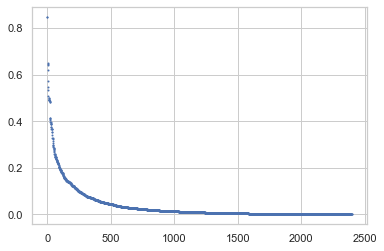

Estimated time to finish: 26.81095576286316
Elapsed time for the computation:  33.976805448532104
((3383230395, 95719227, 0), 0.8765784568084822)


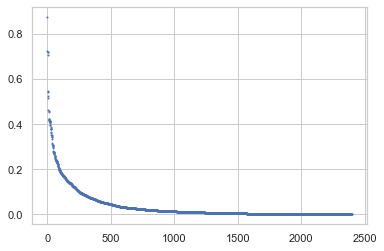

Estimated time to finish: 25.822072982788086
Elapsed time for the computation:  32.01595854759216
((95711361, 1815032088, 0), 0.7969892269559444)


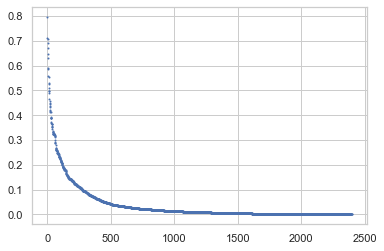

Estimated time to finish: 23.91404366493225
Elapsed time for the computation:  35.39695882797241
((267383938, 4583424155, 0), 0.64765728189085)


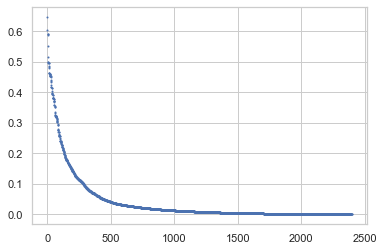

Estimated time to finish: 44.78370022773743
Elapsed time for the computation:  41.59100890159607
((95715421, 95713482, 0), 0.5985321149952272)


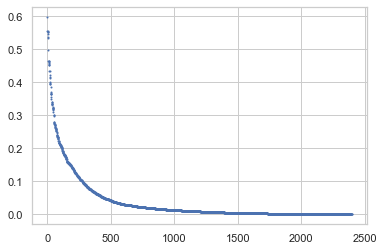

In [22]:
top5_bc = []

for _ in range(0,5):
    # Get betweenness centrality of each edge
    bc = estimated_betweenness_centrality(G, weight='travel_time', normalize='True')
    
    highest_bc = sorted(bc.items(), reverse=True, key= lambda d: d[1])[0]
    bc_vals = sorted(bc.values(), reverse=True)
    print(highest_bc)

    target_edge = highest_bc[0]
    top5_bc.append(target_edge)

    plt.scatter(range(0,len(bc_vals)), bc_vals, s=1)
    plt.show()
    
    G.edges[target_edge]['travel_time'] = 999999999999999 

Top-5 bet. cent. edges:
No. 1 : (271745579, 256203474, 0)
No. 2 : (3383230395, 95719227, 0)
No. 3 : (95711361, 1815032088, 0)
No. 4 : (267383938, 4583424155, 0)
No. 5 : (95715421, 95713482, 0)


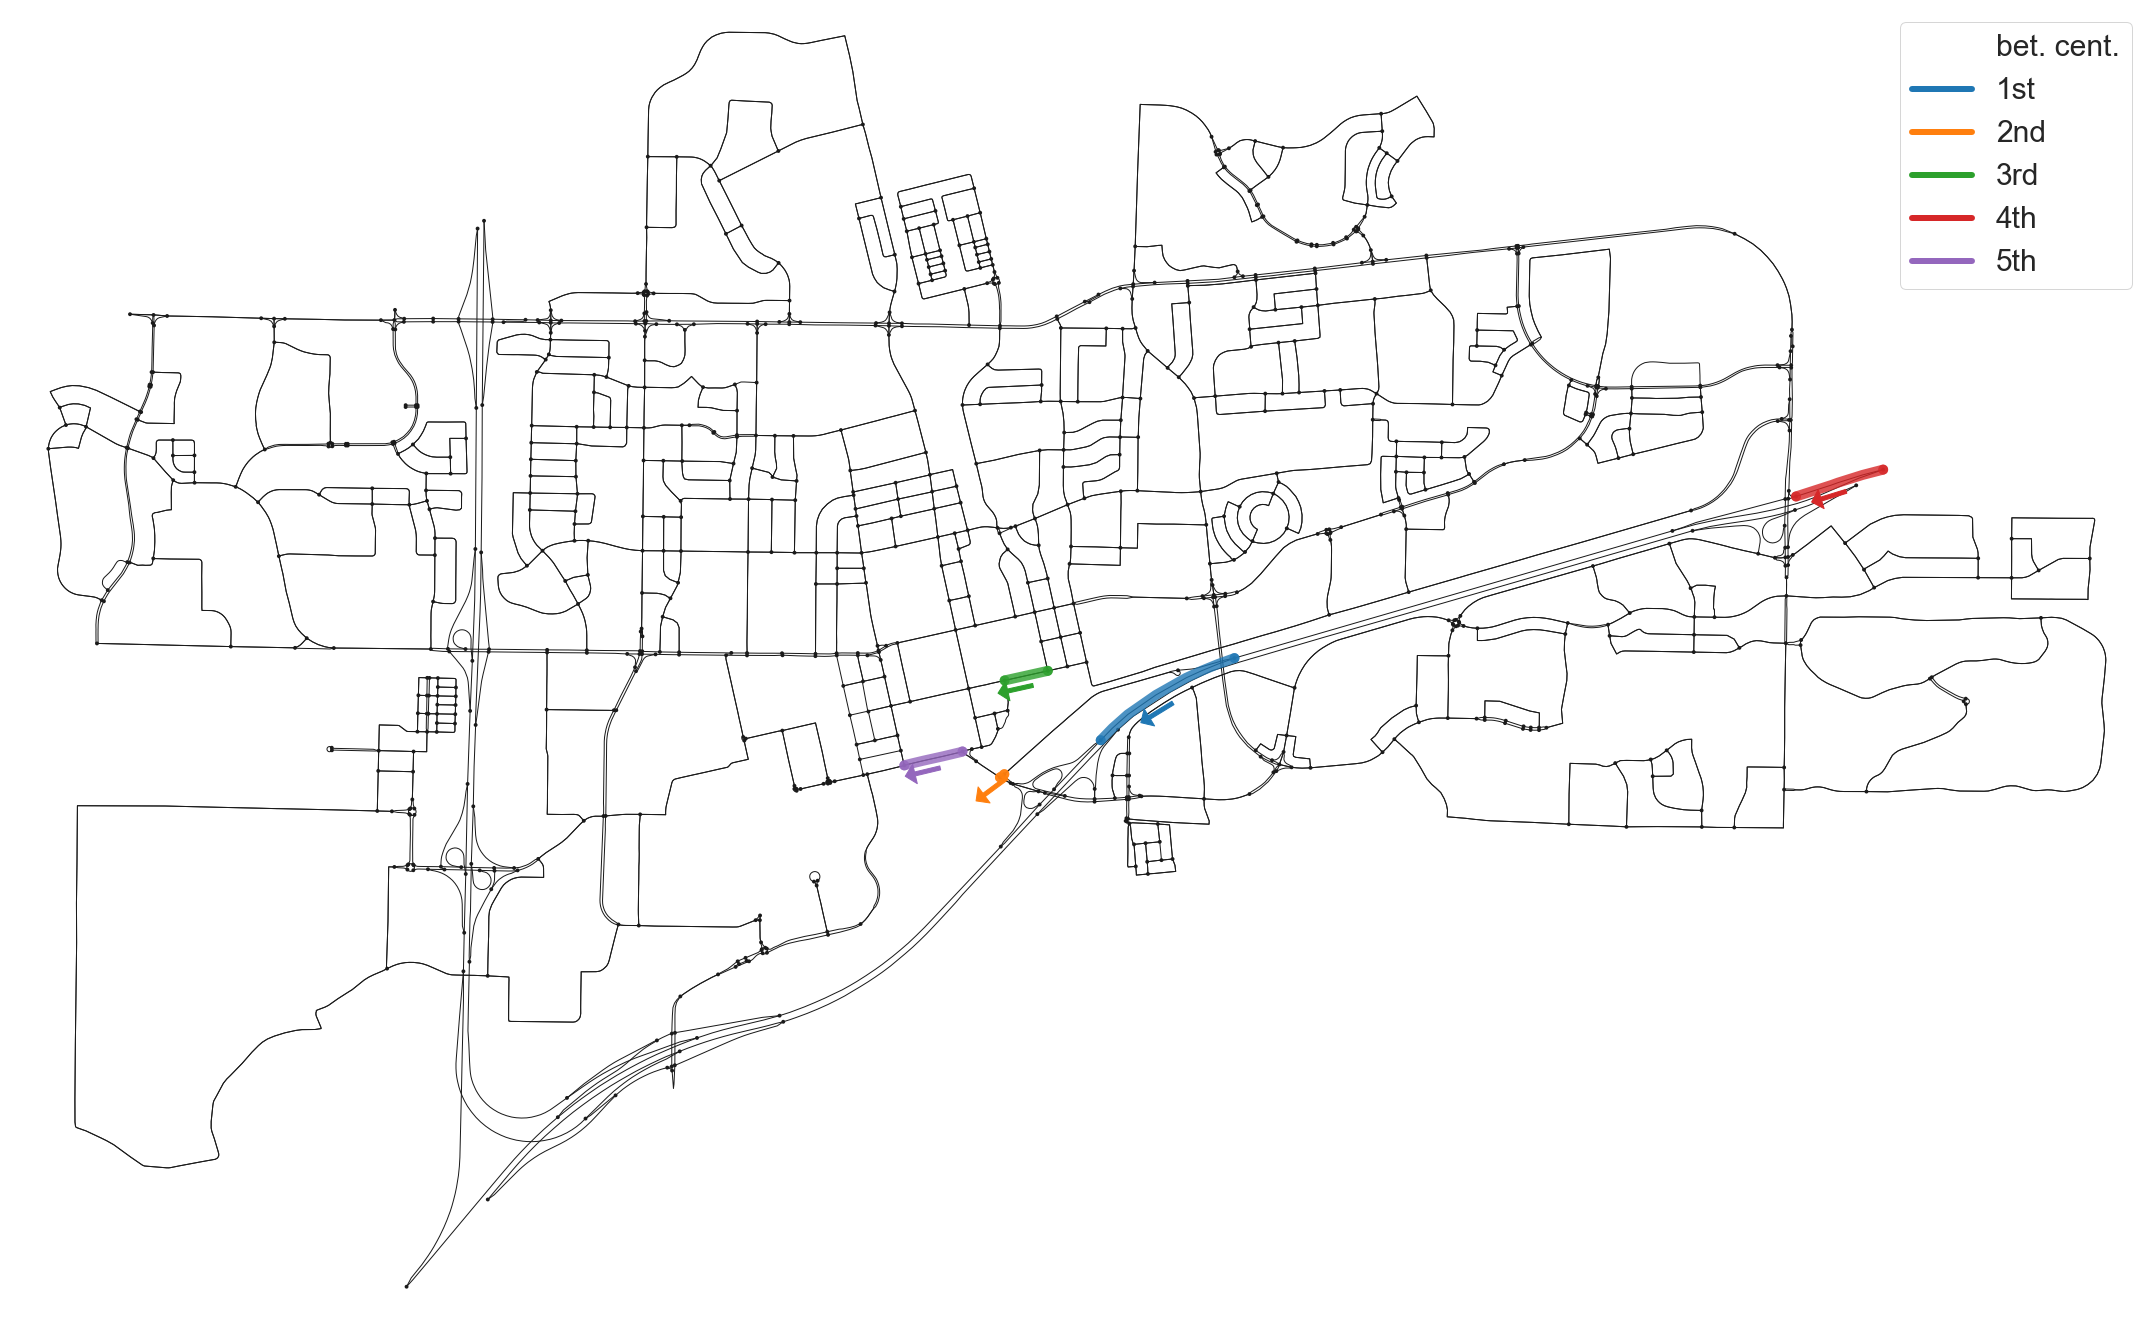

In [23]:
routes = []
for u,v,k in top5_bc:
    rt = [u,v]
    routes.append(rt)

print('Top-5 bet. cent. edges:')
for i, edge in enumerate(top5_bc):
    print('No.',i+1,':' , edge)
    
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = ox.plot.plot_graph_routes(G, routes, figsize=(40,24), route_colors=default_colors[:5], 
                                    edge_color='k', node_color='k', bgcolor='w',
                                    route_linewidths=10, show=False, close=False, route_alpha=0.8)

for i, e in enumerate(routes):
    start_node = e[0]
    end_node = e[1]
    start_coord = (G.nodes[start_node]['x'] - 0.0006, G.nodes[start_node]['y'] - 0.0006)
    end_coord =  (G.nodes[end_node]['x'] - 0.0006, G.nodes[end_node]['y'] - 0.0006)

    # Annotate node ID if needed
    #atk_ax.annotate(start_node, xy=start_coord, color='white', weight='bold')
    #atk_ax.annotate(end_node, xy=end_coord, color='blue', weight='bold')

    middle_coord = (start_coord[0] + 0.5*(end_coord[0] - start_coord[0]), 
                    start_coord[1] + 0.5*(end_coord[1] - start_coord[1]))

    arrow_len = 0.001

    x_s = start_coord[0]
    y_s = start_coord[1]
    x_e = end_coord[0]
    y_e = end_coord[1]
    x_m = middle_coord[0]
    y_m = middle_coord[1]

    x_diff = x_s - x_m
    y_diff = y_s - y_m
    grad = y_diff / x_diff

    x_sign = x_diff / abs(x_diff)
    y_sign = y_diff / abs(y_diff)

    arrow_start_coord = (middle_coord[0] + 0.3*(start_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(start_coord[1] - middle_coord[1]))
    arrow_end_coord = (middle_coord[0] + 0.3*(end_coord[0] - middle_coord[0]), middle_coord[1] + 0.3*(end_coord[1] - middle_coord[1]))    
    dist = (((arrow_start_coord[0]-arrow_end_coord[0])**2 + (arrow_start_coord[1] - arrow_end_coord[1])**2)**0.5)

    if dist < 0.003:
            x_mov = x_sign*((arrow_len**2 / (1 + grad**2))**0.5)
            y_mov = y_sign*((arrow_len**2 - x_mov**2) ** 0.5)
            arrow_start_coord = (middle_coord[0] + x_mov, middle_coord[1] + y_mov)
            arrow_end_coord = (middle_coord[0] - x_mov, middle_coord[1] - y_mov)

    ax.annotate('', xy= arrow_end_coord, color='blue', weight='bold', 
                xytext= arrow_start_coord, textcoords='data', 
                arrowprops=dict(color=default_colors[i], headwidth=20, headlength=10, lw=1))

# Add legend
line_label, = plt.plot([0, 0, 0], label='1st', c='none', linewidth = 0)
line_1st, = plt.plot([0, 0, 0], label='1st', c=default_colors[0], linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='2nd', c=default_colors[1], linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='3rd', c=default_colors[2], linewidth = 6)
line_4th, = plt.plot([0, 0, 0], label='4th', c=default_colors[3], linewidth = 6)
line_5th, = plt.plot([0, 0, 0], label='5th', c=default_colors[4], linewidth = 6)


plt.legend([line_label, line_1st, line_2nd, line_3rd, line_4th, line_5th], 
           ['bet. cent.', '1st', '2nd', '3rd', '4th', '5th'], prop={'size': 30})

plt.show()
plt.close('all')